# Imports

In [1]:
# Freqtrade Workspace

# Notebook Helpers
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

# Standard Imports
from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta
from copy import deepcopy

import attr
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import pandas as pd
import numpy as np
import qgrid
pd.set_option('display.max_rows', 200)

# Resolve CWD
gc.collect()
nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)
        logging.getLogger("distributed.utils_perf").setLevel(logging.ERROR)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.nbtools.preset import LocalPreset, ConfigPreset, FilePreset, CloudPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
PATH_DATA = PATH_MOUNT / "data"
PATH_PRESETS = PATH_MOUNT / "presets"
PATH_STRATEGIES = PATH_PRESETS / ".strategy_files"
DATALOADER = DataLoader(max_n_datasets=5)

# Define custom functions
def foo() -> str:
    return "bar"

env: WANDB_SILENT=true
freqtrade.nbtools.backtest - Initialized DataLoader with 5 max datas.


In [6]:
""" 
Strategy Backtesting Principles:

- In this case, we use "Long only" strategy.

- ZOOM OUT: Test in various market conditions, such as:
   > Bear Period - Profits should slight loss or ranging.
   > Bull Period - Profits must up!
   > Ranging Period - Profits should at least ranging. Up profits are welcome.

- ZOOM IN: Current condition validation: 
   > Test strategy to last 1 month data, determine if it's suitable to dry run.
"""
# List of available file strategies
strats = [it.name.replace(".py", "") for it in PATH_STRATEGIES.glob("*.py")]
paths = [str(it) for it in PATH_STRATEGIES.glob("*.py")]
df_strats = pd.DataFrame({"name": strats, "path": paths})
qgrid.show_grid(df_strats)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# Strategy File Backtesting

In [9]:
# Backtest settings
strategy_classname = "Codex"  # Strategy Filename and Classname must same! 
timerange          = "20160101-"
pairs              = PAIRS_HIGHCAP_NONSTABLE

pairs              = [
    "DOGE/USDT",
    "BTC/USDT", "ETH/USDT", "ADA/USDT", "XRP/USDT", "BCH/USDT", "EOS/USDT", "NEO/USDT", "NANO/USDT", "XMR/USDT", "ZEC/USDT",
]

preset = FilePreset(
    timerange = timerange,
    config_dict = configs.DEFAULT,
    path_to_file = PATH_STRATEGIES / f"{strategy_classname}.py",
    path_data = PATH_DATA,
)

# Optional override
preset.overwrite_config(
    strategy_search_path = PATH_STRATEGIES,
    pairs                = pairs,
#     max_open_trades      = 2,     
#     starting_balance     = 50,   
#     stake_amount         = "unlimited",    
#     timeframe            = "6h", # 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
)

stats, summary = backtest(preset, preset.default_strategy_code, clsname=strategy_classname, dataloader=DATALOADER)
trades = pd.DataFrame(stats["strategy"][strategy_classname]["trades"])
plotting.plot_profits_timerange(
    trades,
    timerange,
    path_mount = PATH_MOUNT,
    name = preset.name
)

Preset name: Codex
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 11 pairs)
freqtrade.nbtools.preset.base_preset - Add strategy search path C:\CS\Python\crypto-collection\freqtrade\mount\presets\.strategy_files
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 11 pairs)
freqtrade.nbtools.preset.base_preset - Add strategy search path C:\CS\Python\crypto-collection\freqtrade\mount\presets\.strategy_files
freqtrade.nbtools.preset.base_preset - Setting config for Codex ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20160101-
freqtrade.nbtools.helper - Strategy using minimal_roi: {'60': 0.01, '30': 0.03, '20': 0.04, '0': 0.05}
freqtrade.nbtools.helper - Strategy using timeframe: 5m
freqtrade.nbtools.helper - Strategy using stoploss: -0.3
freqtrade.nbtools.helper - Strategy using trailing_stop: False
freqtrad

Populating Indicators:   0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\User\.virtualenvs\freqtrade-futures\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\User\.virtualenvs\freqtrade-futures\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


freqtrade.nbtools.helper - "Backtest" executed in 17.60s
freqtrade.nbtools.backtest - Logging preset...
freqtrade.nbtools.helper - "Whole Backtesting Process (Backtest + Log)" executed in 18.26s


ZeroDivisionError: division by zero

# Plot Profits

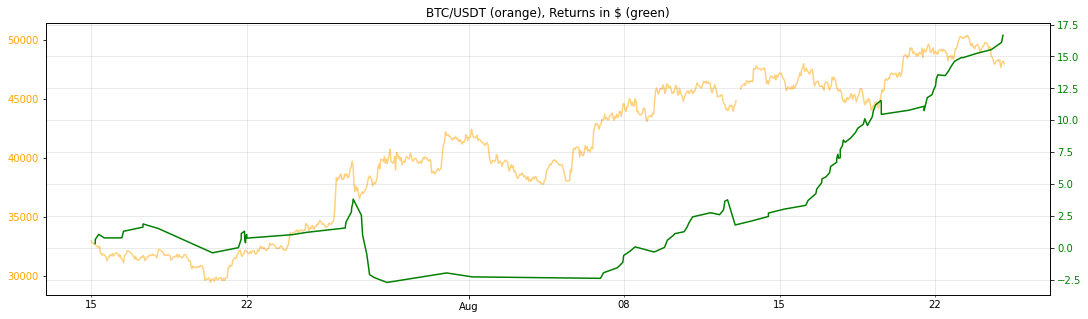

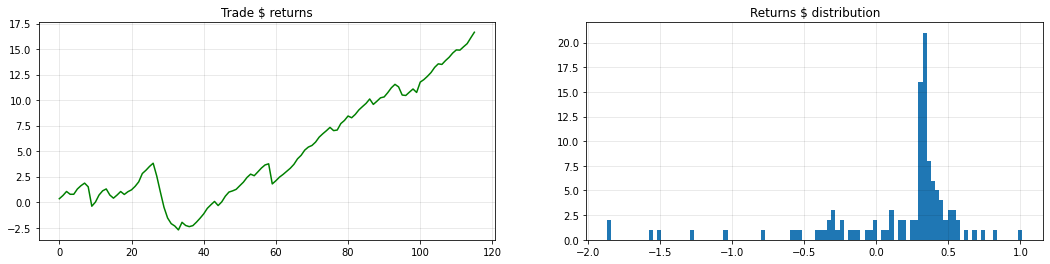

,Portfolio Summary
Min Balance,-2.72
Max Balance,16.65
End Balance,16.65
Trades,116.00
Avg. Profit %,0.96
Avg. Profit $,0.14
Biggest Profit $,1.01
Biggest Loss $,-1.97


In [34]:
plotting.plot_profits(
    trades,
    start = "2021-07-15",
    end = "2021-09-01",
    path_mount = PATH_MOUNT,
    name = preset.name,
)

# Statistics

In [74]:
def process_result_dataframe(result_df):
    result_df = result_df.drop(columns=["profit_mean", "profit_total", "profit_sum"])
    result_df = result_df.sort_values(by=["profit_total_abs"], ascending=False)
    result_df = result_df.round(2)
    return result_df

# Running this cell will print backtest results
results = deepcopy(stats["strategy"][strategy_classname])

# Results per pair
results_per_pair = pd.DataFrame(results["results_per_pair"]).set_index("key")
results_per_pair = process_result_dataframe(results_per_pair)

# Sell reason stats
sells = pd.DataFrame(results['sell_reason_summary']).set_index("sell_reason")
sells = process_result_dataframe(sells)

# Left open trades
left_open_trades = pd.DataFrame(results['left_open_trades']).set_index("key")
left_open_trades = process_result_dataframe(left_open_trades)

# Summary metrics
metrics = text_table_add_metrics(results)
advanced_metrics = deepcopy(stats["metadata"])
advanced_metrics["profit_mean"] = advanced_metrics["profit_mean"] * 100
advanced_metrics["profit_median"] = advanced_metrics["profit_median"] * 100
advanced_metrics["profit_total"] = advanced_metrics["profit_total"] * 100

for key in list(advanced_metrics):
    value = advanced_metrics[key]
    valid = any(isinstance(value, it) for it in [str, int, float, bool])
    
    if not valid:
        del advanced_metrics[key]
        continue
    
    if isinstance(value, float):
        advanced_metrics[key] =  round(value, 3)
    
    advanced_metrics[key] = [advanced_metrics[key]]
    
advanced_metrics_df = pd.DataFrame(advanced_metrics)
    
print("Results Per Pair")
display(results_per_pair)
print("Sell Reasons")
display(sells)
print("Left Open Trades")
display(left_open_trades)
print("Freqtrade Summary Metrics")
print("=" * 48 + "\n" + metrics + "\n" + "=" * 48)
print("Advanced Metrics")
print("Preset Name:", advanced_metrics_df["preset_name"][0])
display(advanced_metrics_df.drop(columns=["preset_name"]).T)# Running this cell will print backtest results
results = stats["strategy"][strategy_classname]

# Results per pair
results_per_pair = pd.DataFrame(results["results_per_pair"])
results_per_pair_df = results_per_pair.set_index("key").drop(columns=["profit_mean", "profit_total"])
results_per_pair_df = results_per_pair_df.sort_values(by=["profit_total_pct"], ascending=False)
results_per_pair_df.round(2)

# Sell reason stats
sells = pd.DataFrame(results['sell_reason_summary'])
sells = sells.drop(columns=["profit_mean", "profit_total"]).set_index("sell_reason")

# Left open trades
left_open_trades = pd.DataFrame(results['left_open_trades'])
left_open_trades = left_open_trades.drop(columns=["profit_mean", "profit_total"]).set_index("key")

# Summary metrics
metrics = text_table_add_metrics(results)

print("Results Per Pair")
display(results_per_pair_df.round(2))
print("Sell Reasons")
display(sells.round(2))
print("Left Open Trades")
display(left_open_trades.round(2))
print("Summary")
print("=" * 48 + "\n" + metrics + "\n" + "=" * 48)

Results Per Pair


,trades,profit_mean_pct,profit_sum_pct,profit_total_abs,profit_total_pct,duration_avg,wins,draws,losses
key,,,,,,,,,
TOTAL,5107,0.86,4375.53,656.99,65.70,2:46:00,4068,55,984
DOGE/USDT,80,2.86,228.69,34.34,3.43,1:51:00,70,0,10
BTT/USDT,73,2.54,185.69,27.88,2.79,2:46:00,60,1,12
ETC/USDT,95,1.93,183.29,27.52,2.75,2:21:00,86,0,9
MATIC/USDT,108,1.68,181.53,27.26,2.73,2:04:00,91,0,17
LUNA/USDT,136,1.25,169.52,25.45,2.55,2:50:00,115,1,20
CHZ/USDT,94,1.64,154.00,23.12,2.31,1:50:00,80,0,14
ONE/USDT,97,1.45,140.76,21.14,2.11,1:43:00,81,0,16
FIL/USDT,78,1.63,127.34,19.12,1.91,2:57:00,63,2,13


Sell Reasons


,trades,wins,draws,losses,profit_mean_pct,profit_sum_pct,profit_total_abs,profit_total_pct
sell_reason,,,,,,,,
roi,4079,4024,55,0,2.16,8822.47,1324.69,1470.41
force_sell,1,0,0,1,-1.72,-1.72,-0.26,-0.29
sell_signal,21,0,0,21,-5.72,-120.03,-18.02,-20.01
stop_loss,149,0,0,149,-10.18,-1516.79,-227.75,-252.80
trailing_stop_loss,857,44,0,813,-3.28,-2808.40,-421.68,-468.07


Left Open Trades


,trades,profit_mean_pct,profit_sum_pct,profit_total_abs,profit_total_pct,duration_avg,wins,draws,losses
key,,,,,,,,,
ALGO/USDT,1,-1.72,-1.72,-0.26,-0.03,3:00:00,0,0,1
TOTAL,1,-1.72,-1.72,-0.26,-0.03,3:00:00,0,0,1


Freqtrade Summary Metrics
| Metric                 | Value               |
|------------------------+---------------------|
| Backtesting from       | 2020-12-26 19:00:00 |
| Backtesting to         | 2021-08-19 12:30:00 |
| Max open trades        | 6                   |
|                        |                     |
| Total/Daily Avg Trades | 5107 / 21.73        |
| Starting balance       | 1000.000 USDT       |
| Final balance          | 1656.985 USDT       |
| Absolute profit        | 656.985 USDT        |
| Total profit %         | 65.7%               |
| Avg. stake amount      | 15.000 USDT         |
| Total trade volume     | 76605.000 USDT      |
|                        |                     |
| Best Pair              | DOGE/USDT 228.69%   |
| Worst Pair             | ALGO/USDT -33.78%   |
| Best trade             | XLM/USDT 27.87%     |
| Worst trade            | THETA/USDT -10.18%  |
| Best day               | 27.047 USDT         |
| Worst day              | -7.896 USDT     

,0
random_name,depressed-sasuke-phone
preset_type,FilePreset
backtest_date,2021-08-23 11:23:42
leverage,1
direction,long
is_hedging,False
fee,0.001
num_pairs,61
data_source,binance
win_rate,0.797


Results Per Pair


,trades,profit_mean_pct,profit_sum,profit_sum_pct,profit_total_abs,profit_total_pct,duration_avg,wins,draws,losses
key,,,,,,,,,,
TOTAL,5107,0.86,43.76,4375.53,656.99,65.70,2:46:00,4068,55,984
DOGE/USDT,80,2.86,2.29,228.69,34.34,3.43,1:51:00,70,0,10
BTT/USDT,73,2.54,1.86,185.69,27.88,2.79,2:46:00,60,1,12
ETC/USDT,95,1.93,1.83,183.29,27.52,2.75,2:21:00,86,0,9
MATIC/USDT,108,1.68,1.82,181.53,27.26,2.73,2:04:00,91,0,17
LUNA/USDT,136,1.25,1.70,169.52,25.45,2.55,2:50:00,115,1,20
CHZ/USDT,94,1.64,1.54,154.00,23.12,2.31,1:50:00,80,0,14
ONE/USDT,97,1.45,1.41,140.76,21.14,2.11,1:43:00,81,0,16
FIL/USDT,78,1.63,1.27,127.34,19.12,1.91,2:57:00,63,2,13


Sell Reasons


,trades,wins,draws,losses,profit_mean_pct,profit_sum,profit_sum_pct,profit_total_abs,profit_total_pct
sell_reason,,,,,,,,,
roi,4079,4024,55,0,2.16,88.22,8822.47,1324.69,1470.41
trailing_stop_loss,857,44,0,813,-3.28,-28.08,-2808.40,-421.68,-468.07
stop_loss,149,0,0,149,-10.18,-15.17,-1516.79,-227.75,-252.80
sell_signal,21,0,0,21,-5.72,-1.20,-120.03,-18.02,-20.01
force_sell,1,0,0,1,-1.72,-0.02,-1.72,-0.26,-0.29


Left Open Trades


,trades,profit_mean_pct,profit_sum,profit_sum_pct,profit_total_abs,profit_total_pct,duration_avg,wins,draws,losses
key,,,,,,,,,,
ALGO/USDT,1,-1.72,-0.02,-1.72,-0.26,-0.03,3:00:00,0,0,1
TOTAL,1,-1.72,-0.02,-1.72,-0.26,-0.03,3:00:00,0,0,1


Summary
| Metric                 | Value               |
|------------------------+---------------------|
| Backtesting from       | 2020-12-26 19:00:00 |
| Backtesting to         | 2021-08-19 12:30:00 |
| Max open trades        | 6                   |
|                        |                     |
| Total/Daily Avg Trades | 5107 / 21.73        |
| Starting balance       | 1000.000 USDT       |
| Final balance          | 1656.985 USDT       |
| Absolute profit        | 656.985 USDT        |
| Total profit %         | 65.7%               |
| Avg. stake amount      | 15.000 USDT         |
| Total trade volume     | 76605.000 USDT      |
|                        |                     |
| Best Pair              | DOGE/USDT 228.69%   |
| Worst Pair             | ALGO/USDT -33.78%   |
| Best trade             | XLM/USDT 27.87%     |
| Worst trade            | THETA/USDT -10.18%  |
| Best day               | 27.047 USDT         |
| Worst day              | -7.896 USDT         |
| Days win/d

In [26]:
qgrid.show_grid(trades)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [78]:
DATALOADER.clear()
gc.collect()

0